In [18]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [21]:
train = pd.read_csv('train.csv')

In [22]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" +
          str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int32  
 11  Ecology_3      10000 non-null  int32  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [120]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


In [87]:
# Заполняем пропуски
len(train) - train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [76]:
# Замена нулей медианой
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train['LifeSquare'].median()
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

In [ ]:
#Дропаем Id
train = train.drop('Id', axis = 'columns')
# df = df[df.columns[:-1]]

In [126]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.917500,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.275139,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [122]:
# Производим замену в полях Ecology_2 Ecology_3 и Shops_2 А = 0 В = 1
train.loc[train['Ecology_2'] == 'A', 'Ecology_2'] = 0
train.loc[train['Ecology_2'] == 'B', 'Ecology_2'] = 1
train.loc[train['Ecology_3'] == 'A', 'Ecology_3'] = 0
train.loc[train['Ecology_3'] == 'B', 'Ecology_3'] = 1
train.loc[train['Shops_2'] == 'A', 'Shops_2'] = 0
train.loc[train['Shops_2'] == 'B', 'Shops_2'] = 1
#Сразу меняем тип данных на инт
train['Ecology_2'] = train['Ecology_2'].astype(int)
train['Ecology_3'] = train['Ecology_3'].astype(int)
train['Shops_2'] = train['Shops_2'].astype(int)

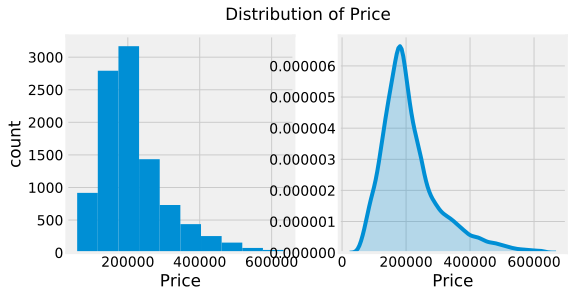

In [59]:
plt.figure(figsize = (8, 4))

plt.subplot(121)
train['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [98]:
target_mean = round(train['Price'].mean(), 2)
target_median = train['Price'].median()
target_mode = train['Price'].mode()[0]

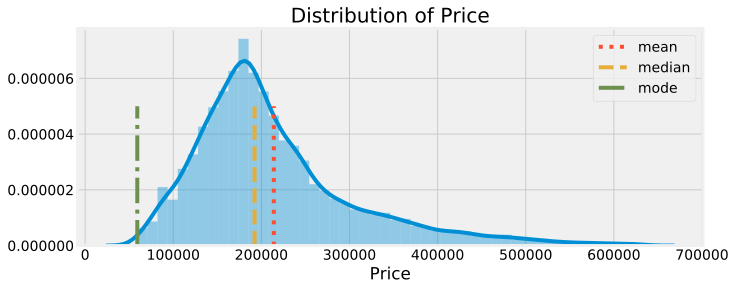

In [138]:
plt.figure(figsize = (10, 4))

sns.distplot(train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [139]:
train.shape

(10000, 20)

In [147]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


In [146]:
train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [173]:
# Создаем наборы для стандартизации
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',]
target_name = ['Price']

In [176]:
# Создаем новый датасет из ключевых признаков
df = train[feature_names + target_name]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Social_1       10000 non-null  int64  
 10  Social_2       10000 non-null  int64  
 11  Social_3       10000 non-null  int64  
 12  Healthcare_1   10000 non-null  float64
 13  Helthcare_2    10000 non-null  int64  
 14  Shops_1        10000 non-null  int64  
 15  Price          10000 non-null  float64
dtypes: float64(8), int64(8)
memory usage: 1.2 MB


In [186]:
# Стандартизируем все однородные признаки
feature_names_for_stand = df[feature_names].select_dtypes(include='float64').columns.tolist()
scaler = StandardScaler()
stand_features_float = scaler.fit_transform(df[feature_names_for_stand])

In [185]:
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Healthcare_1']

In [187]:
stand_features = scaler.fit_transform(df[feature_names])

In [179]:
df_float=df

In [180]:
df_all=df

In [181]:
df_float[feature_names_for_stand] = pd.DataFrame(stand_features_float, columns=feature_names_for_stand)

In [182]:
df_all[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [183]:
df_float.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,-0.353348,0.130439,-0.395780,-0.089070,-0.009569,-0.291306,-0.532703,-0.010081,-0.250529,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,184966.930730
1,-0.215687,1.321667,0.444867,0.049389,0.060460,-0.291306,-0.532703,-0.010036,-0.998053,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,300009.450063
2,0.059635,0.130439,-0.539842,-0.092270,-0.219657,-0.100498,-0.089940,-0.010086,-0.581588,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,220925.908524
3,0.174352,0.130439,-0.140699,0.214937,0.095474,-0.100498,0.647998,-0.010041,2.680470,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,175616.227217
4,1.115034,-1.060788,-0.791473,-0.163040,0.025445,0.471924,-0.089940,-0.010046,-0.894969,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,150226.531644


In [184]:
df_all.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,-0.353348,0.130439,-0.395780,-0.089070,-0.009569,-0.291306,-0.532703,-0.010081,-0.250529,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,184966.930730
1,-0.215687,1.321667,0.444867,0.049389,0.060460,-0.291306,-0.532703,-0.010036,-0.998053,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,300009.450063
2,0.059635,0.130439,-0.539842,-0.092270,-0.219657,-0.100498,-0.089940,-0.010086,-0.581588,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,220925.908524
3,0.174352,0.130439,-0.140699,0.214937,0.095474,-0.100498,0.647998,-0.010041,2.680470,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,175616.227217
4,1.115034,-1.060788,-0.791473,-0.163040,0.025445,0.471924,-0.089940,-0.010046,-0.894969,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,150226.531644
